# Importing libraries

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
plt.style.use('default')
from skimage.io import imread
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


import keras
import keras.backend as K
from keras.preprocessing.image import  ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
from keras.utils.np_utils import to_categorical

from keras.applications.vgg16 import VGG16
from keras.utils.data_utils import get_file

from keras import layers
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint


from sklearn.model_selection import train_test_split



# Reading dataset

In [2]:
x = []
y = []
class_names = []
parent_directory = "C:/Users/Admin/Desktop/leaves28"

for i,folder in enumerate(os.listdir(parent_directory)):
    print(i,folder)
    class_names.append(folder)
    folder_directory = os.path.join(parent_directory,folder)
    files = os.listdir(folder_directory)
    #will inspect only 1 image per folder
    for file in files:
        file_path = os.path.join(folder_directory,file)
        image = load_img(file_path,target_size=(224,224))
        image = img_to_array(image)/255.
        x.append(image)
        y.append(i)

x = np.array(x)
y = to_categorical(y)

0 black spot
1 canker
2 greening
3 healthy
4 melanose


# Spitting dataset into train, test and validation

In [3]:
x_train, _x, y_train, _y = train_test_split(x,y,test_size=0.2, stratify = y, random_state = 1)
x_valid,x_test, y_valid, y_test = train_test_split(_x,_y,test_size=0.5, stratify = _y, random_state = 1)

print("train data:",x_train.shape,y_train.shape)
print("validation data:",x_valid.shape,y_valid.shape)
print("test data:",x_test.shape,y_test.shape)

train data: (700, 224, 224, 3) (700, 5)
validation data: (88, 224, 224, 3) (88, 5)
test data: (88, 224, 224, 3) (88, 5)


# Model

In [2]:
import tensorflow as tf
IMG_SHAPE = (224, 224, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

In [3]:
base_model.trainable = True
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [6]:

model = Sequential([
    layers.Conv2D(16,(3,3),name="conv1",input_shape=(224,224,3),activation="relu",padding="same"),   
    layers.MaxPool2D((2,2),name="pool1"),
    layers.Dropout(0.1),
    layers.Conv2D(32,(3,3),name="conv2",padding="same"),
    layers.Activation("relu"),
    layers.MaxPool2D((2,2),name="pool2"),
    layers.Dropout(0.1),
    layers.Conv2D(32,(3,3),name="conv3",padding="same"),
    layers.Activation("relu"),
    layers.MaxPool2D((2,2),name="pool3"),
    layers.Dropout(0.1),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dropout(0.1),
  
    layers.Dense(5,name="prepredictions"),
    layers.Activation("softmax",name="prediction")
]
)

model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["acc"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 224, 224, 16)      448       
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 16)      0         
                                                                 
 dropout (Dropout)           (None, 112, 112, 16)      0         
                                                                 
 conv2 (Conv2D)              (None, 112, 112, 32)      4640      
                                                                 
 activation (Activation)     (None, 112, 112, 32)      0         
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 32)        0         
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 32)        0

# Data augmentation

In [4]:
ckpt = ModelCheckpoint("D:\\model\\ModelCheckpoint_mobilenet.hdf5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

t_gen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)

v_gen = ImageDataGenerator()
train_gen = t_gen.flow(x_train,y_train,batch_size=32)
valid_gen = v_gen.flow(x_valid,y_valid,batch_size=32)

In [8]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch = train_gen.n // 32,
    callbacks = [ckpt],
    validation_data = valid_gen,
    validation_steps = valid_gen.n // 32,
    epochs=30)

C:\Users\Admin\AppData\Local\Temp\ipykernel_12356\298488446.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.4246 - acc: 0.3967
Epoch 1: val_loss improved from inf to 1.13730, saving model to D:\model\ModelCheckpoint_mobilenet.hdf5
21/21 [==============================] - 37s 2s/step - loss: 1.4246 - acc: 0.3967 - val_loss: 1.1373 - val_acc: 0.6406
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 0.9791 - acc: 0.5464
Epoch 2: val_loss improved from 1.13730 to 0.88765, saving model to D:\model\ModelCheckpoint_mobilenet.hdf5
21/21 [==============================] - 33s 2s/step - loss: 0.9791 - acc: 0.5464 - val_loss: 0.8876 - val_acc: 0.5781
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 0.8285 - acc: 0.6437
Epoch 3: val_loss improved from 0.88765 to 0.77212, saving model to D:\model\ModelCheckpoint_mobilenet.hdf5
21/21 [==============================] - 34s 2s/step - loss: 0.8285 - acc: 0.6437 - val_loss: 0.7721 - val_acc: 0.6562
Epoch 4/30
21/21 [==============================] - ETA:

# Plotting accuracy and loss graph

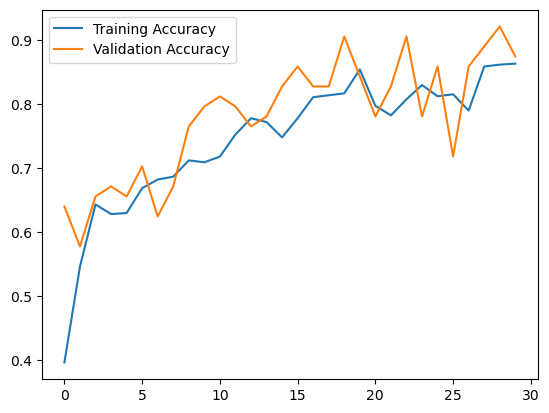

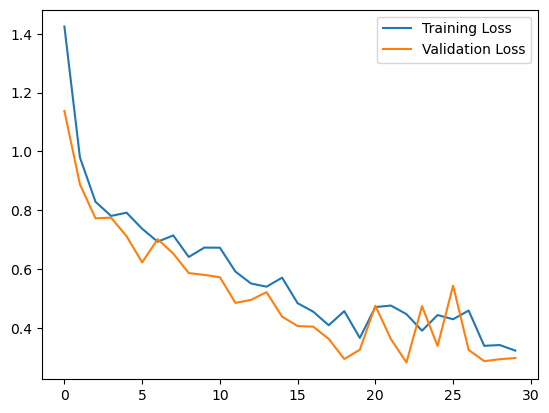

In [9]:
plt.plot(history.history["acc"],label="Training Accuracy")
plt.plot(history.history["val_acc"],label="Validation Accuracy")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Training Loss")
plt.plot(history.history["val_loss"],label="Validation Loss")
plt.legend()
plt.show()

In [10]:
model.save('D:\\model\\new_MobileNet.h5')

In [11]:
y_pred = model.predict(x_test)
y_pred

3/3 [==============================] - 1s 208ms/step


array([[3.92549634e-02, 6.23890082e-05, 9.60606873e-01, 5.08125340e-05,
        2.50138710e-05],
       [6.97987616e-01, 1.92050857e-03, 2.96594501e-01, 3.39677953e-03,
        1.00486730e-04],
       [4.65523869e-01, 7.13246269e-03, 5.20799220e-01, 6.49960525e-03,
        4.47995044e-05],
       [6.84333086e-01, 2.67317722e-04, 3.14370632e-01, 1.02052197e-03,
        8.51644654e-06],
       [1.19969778e-19, 5.22805609e-26, 2.78343898e-19, 4.31334927e-32,
        1.00000000e+00],
       [2.52497256e-01, 3.65999229e-02, 7.00180352e-01, 1.02087362e-02,
        5.13777370e-04],
       [3.29369932e-01, 6.59835106e-03, 6.58176303e-01, 5.68800699e-03,
        1.67317616e-04],
       [5.57987750e-01, 6.11325959e-03, 4.15094942e-01, 2.03690212e-02,
        4.34952264e-04],
       [2.53516406e-01, 7.78903998e-03, 7.19524682e-01, 1.83819123e-02,
        7.87983299e-04],
       [2.92661130e-01, 2.71223746e-02, 5.70587635e-01, 1.06578834e-01,
        3.05001088e-03],
       [9.51401412e-01, 3.7544

In [12]:
#check the model metrics
print(model.metrics_names)

#evaluate training data
print(model.evaluate(x= x_train, y = y_train))

#evaluate  validation data
print(model.evaluate(x= x_valid, y = y_valid))

#evaluate  test data
print(model.evaluate(x= x_test, y = y_test))     

['loss', 'acc']
22/22 [==============================] - 5s 222ms/step - loss: 0.2614 - acc: 0.9229
[0.2614305019378662, 0.9228571653366089]
3/3 [==============================] - 1s 200ms/step - loss: 0.2803 - acc: 0.8977
[0.2803371250629425, 0.8977272510528564]
3/3 [==============================] - 1s 187ms/step - loss: 0.2853 - acc: 0.9205
[0.2853381931781769, 0.9204545617103577]


# Confusion matrix

In [13]:
from sklearn.metrics import classification_report

report = classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=class_names)

print(report)


              precision    recall  f1-score   support

  black spot       1.00      0.71      0.83        17
      canker       0.89      1.00      0.94        17
    greening       0.83      1.00      0.91        20
     healthy       0.86      1.00      0.92         6
    melanose       1.00      0.93      0.96        28

    accuracy                           0.92        88
   macro avg       0.92      0.93      0.91        88
weighted avg       0.93      0.92      0.92        88



In [15]:

#true label
y_true = np.argmax(y_test,axis=1)

#prediction label
Y_pred = model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)

print(y_true)
print()
print(y_pred)

3/3 [==============================] - 1s 263ms/step
[2 0 0 0 4 2 0 0 2 2 0 1 1 1 2 0 0 2 1 3 1 4 4 4 0 4 4 3 4 2 3 1 1 0 4 2 4
 4 0 2 3 1 4 0 1 4 1 4 4 2 1 4 4 2 4 4 4 4 4 2 2 0 0 4 4 4 4 1 2 1 2 2 4 1
 0 2 2 4 3 2 2 0 0 1 1 1 4 3]

[2 0 2 0 4 2 2 0 2 2 0 1 1 1 2 0 0 2 1 3 1 4 4 3 0 4 4 3 4 2 3 1 1 0 4 2 4
 4 0 2 3 1 4 0 1 4 1 4 4 2 1 1 4 2 4 4 4 4 4 2 2 1 2 4 4 4 4 1 2 1 2 2 4 1
 2 2 2 4 3 2 2 0 0 1 1 1 4 3]


Normalized confusion matrix
[[0.71 0.06 0.24 0.   0.  ]
 [0.   1.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.  ]
 [0.   0.   0.   1.   0.  ]
 [0.   0.04 0.   0.04 0.93]]


<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

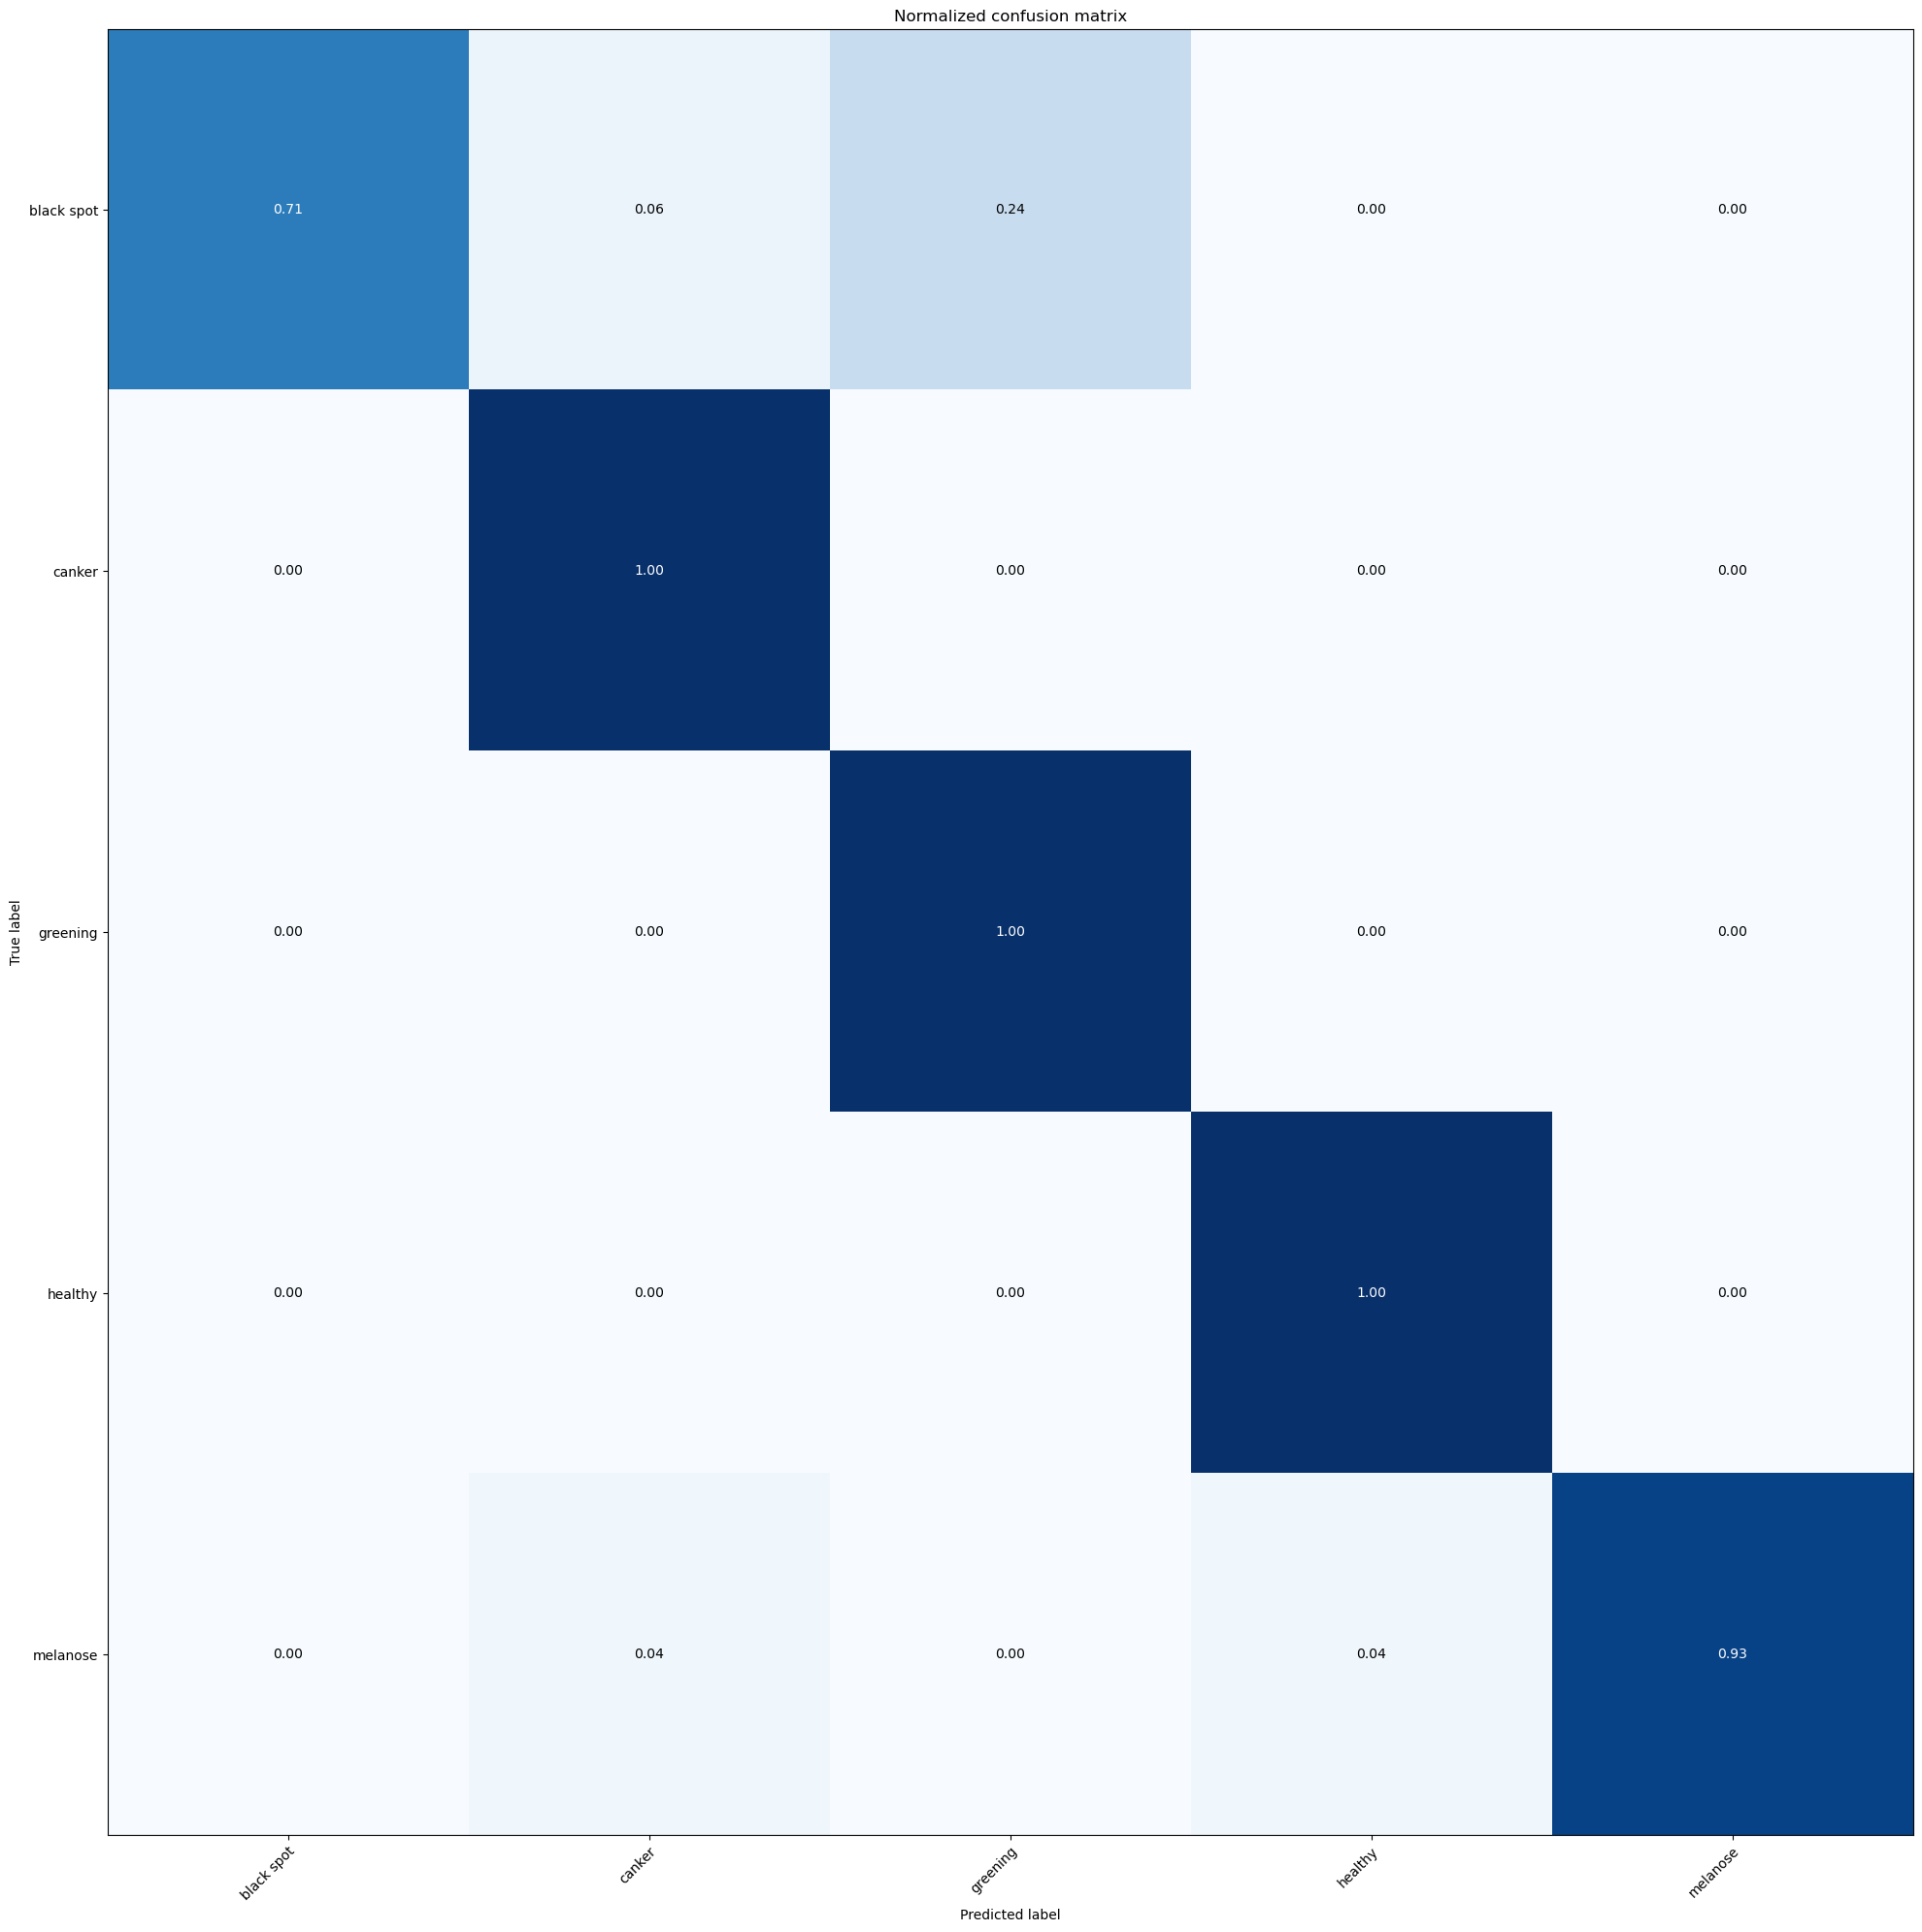

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig, ax = plt.subplots(figsize=(20,20))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')


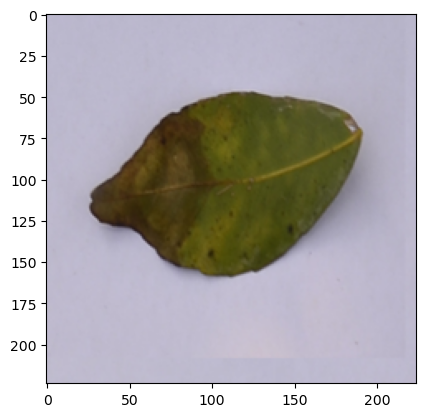

The actual disease name: 0 : black spot
1/1 [==============================] - 0s 55ms/step
Predicted Value: [4.66e-01 7.13e-03 5.21e-01 6.50e-03 4.48e-05]
Predicted disease: 2 : greening
Incorrectly predicted
Correct label : black spot


In [17]:
n = 2

plt.imshow(x_test[n])
plt.show()

true_label = np.argmax(y_test,axis=1)[n]
print("The actual disease name:",true_label,":",class_names[true_label])
prediction = model.predict(x_test[n][np.newaxis,...])[0]
print("Predicted Value:",prediction)
predicted_label = np.argmax(prediction)
print("Predicted disease:",predicted_label,":",class_names[predicted_label])

if true_label == predicted_label:
    print("Correctly Predicted")
else:
    print('Incorrectly predicted')
    print('Correct label :',class_names[true_label])

# InceptionV3 model

In [3]:
from tensorflow.keras.applications import InceptionV3


In [4]:
import tensorflow as tf
IMG_SHAPE = (224, 224, 3)
base_model1 = InceptionV3(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

In [5]:
base_model1.trainable = True
base_model1.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [8]:

model1 = Sequential([
    layers.Conv2D(16,(3,3),name="conv1",input_shape=(224,224,3),activation="relu",padding="same"),   
    layers.MaxPool2D((2,2),name="pool1"),
    layers.Dropout(0.1),
    layers.Conv2D(32,(3,3),name="conv2",padding="same"),
    layers.Activation("relu"),
    layers.MaxPool2D((2,2),name="pool2"),
    layers.Dropout(0.1),
    layers.Conv2D(64,(3,3),name="conv3",padding="same"),
    layers.Activation("relu"),
    layers.MaxPool2D((2,2),name="pool3"),
    layers.Dropout(0.1),
    layers.Flatten(),
    layers.Dense(128,activation="relu"),
    layers.Dropout(0.1),
  
    layers.Dense(5,name="prepredictions"),
    layers.Activation("softmax",name="prediction")
]
)

model1.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["acc"])

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 224, 224, 16)      448       
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 16)      0         
                                                                 
 dropout (Dropout)           (None, 112, 112, 16)      0         
                                                                 
 conv2 (Conv2D)              (None, 112, 112, 32)      4640      
                                                                 
 activation_94 (Activation)  (None, 112, 112, 32)      0         
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 32)        0         
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 32)        0

In [9]:
history = model1.fit_generator(
    train_gen,
    steps_per_epoch = train_gen.n // 32,
    callbacks = [ckpt],
    validation_data = valid_gen,
    validation_steps = valid_gen.n // 32,
    epochs=30)

C:\Users\Admin\AppData\Local\Temp\ipykernel_9316\630999120.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model1.fit_generator(


Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.9078 - acc: 0.3458
Epoch 1: val_loss improved from inf to 1.19780, saving model to D:\model\ModelCheckpoint_mobilenet.hdf5
21/21 [==============================] - 18s 832ms/step - loss: 1.9078 - acc: 0.3458 - val_loss: 1.1978 - val_acc: 0.5312
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 0.9815 - acc: 0.5629
Epoch 2: val_loss improved from 1.19780 to 0.85262, saving model to D:\model\ModelCheckpoint_mobilenet.hdf5
21/21 [==============================] - 17s 804ms/step - loss: 0.9815 - acc: 0.5629 - val_loss: 0.8526 - val_acc: 0.6406
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 0.8441 - acc: 0.6153
Epoch 3: val_loss improved from 0.85262 to 0.80136, saving model to D:\model\ModelCheckpoint_mobilenet.hdf5
21/21 [==============================] - 17s 809ms/step - loss: 0.8441 - acc: 0.6153 - val_loss: 0.8014 - val_acc: 0.6562
Epoch 4/30
21/21 [=============================

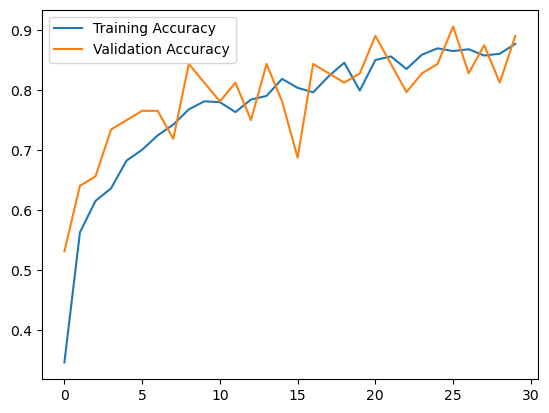

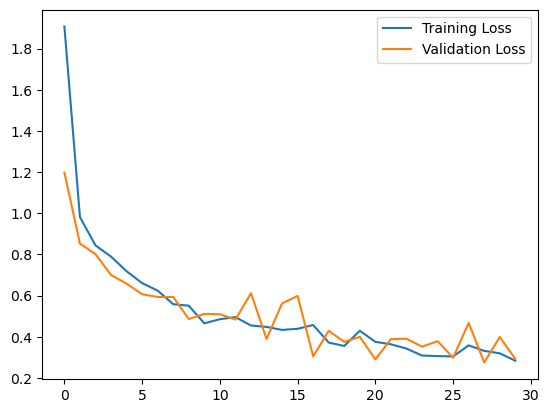

In [10]:
plt.plot(history.history["acc"],label="Training Accuracy")
plt.plot(history.history["val_acc"],label="Validation Accuracy")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Training Loss")
plt.plot(history.history["val_loss"],label="Validation Loss")
plt.legend()
plt.show()

In [10]:
model1.save('D:\\model\\new_inceptionV3.h5')

In [11]:
y_pred = model1.predict(x_test)
y_pred

3/3 [==============================] - 0s 96ms/step


array([[6.62635686e-03, 8.36309189e-10, 9.93373632e-01, 1.46954272e-11,
        8.68702221e-10],
       [7.02404678e-01, 3.56514449e-03, 2.91249782e-01, 2.73137912e-03,
        4.90844031e-05],
       [6.46627069e-01, 1.85038918e-03, 3.50918233e-01, 6.02308370e-04,
        2.00123895e-06],
       [7.06338763e-01, 5.60735025e-05, 2.93576300e-01, 2.83088229e-05,
        4.96967971e-07],
       [1.55234902e-31, 4.97596140e-29, 1.72908804e-26, 0.00000000e+00,
        1.00000000e+00],
       [4.31908637e-01, 1.98314874e-03, 5.64311683e-01, 1.71333679e-03,
        8.31380312e-05],
       [6.95198119e-01, 1.75638217e-03, 3.01876336e-01, 1.16723601e-03,
        1.89355785e-06],
       [3.94058585e-01, 8.67490005e-03, 5.80346048e-01, 1.57871153e-02,
        1.13333110e-03],
       [3.81158262e-01, 1.28847407e-03, 6.16921008e-01, 6.05246285e-04,
        2.70892961e-05],
       [4.63902891e-01, 8.98690021e-04, 5.34095109e-01, 1.08323235e-03,
        2.01456878e-05],
       [5.08552313e-01, 7.8002

In [12]:
#check the model metrics
print(model1.metrics_names)

#evaluate training data
print(model1.evaluate(x= x_train, y = y_train))

#evaluate  validation data
print(model1.evaluate(x= x_valid, y = y_valid))

#evaluate  test data
print(model1.evaluate(x= x_test, y = y_test))     

['loss', 'acc']
22/22 [==============================] - 3s 126ms/step - loss: 0.2222 - acc: 0.9071
[0.22223487496376038, 0.9071428775787354]
3/3 [==============================] - 0s 122ms/step - loss: 0.2582 - acc: 0.8977
[0.2581833600997925, 0.8977272510528564]
3/3 [==============================] - 0s 122ms/step - loss: 0.2693 - acc: 0.9091
[0.26934871077537537, 0.9090909361839294]


In [13]:
from sklearn.metrics import classification_report

report = classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=class_names)

print(report)


              precision    recall  f1-score   support

  black spot       1.00      0.71      0.83        17
      canker       0.80      0.94      0.86        17
    greening       0.83      1.00      0.91        20
     healthy       1.00      0.83      0.91         6
    melanose       1.00      0.96      0.98        28

    accuracy                           0.91        88
   macro avg       0.93      0.89      0.90        88
weighted avg       0.92      0.91      0.91        88



In [14]:

#true label
y_true = np.argmax(y_test,axis=1)

#prediction label
Y_pred = model1.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)

print(y_true)
print()
print(y_pred)

3/3 [==============================] - 0s 111ms/step
[2 0 0 0 4 2 0 0 2 2 0 1 1 1 2 0 0 2 1 3 1 4 4 4 0 4 4 3 4 2 3 1 1 0 4 2 4
 4 0 2 3 1 4 0 1 4 1 4 4 2 1 4 4 2 4 4 4 4 4 2 2 0 0 4 4 4 4 1 2 1 2 2 4 1
 0 2 2 4 3 2 2 0 0 1 1 1 4 3]

[2 0 0 0 4 2 0 2 2 2 0 1 1 1 2 0 2 2 1 3 1 4 4 4 0 4 4 1 4 2 3 1 1 0 4 2 4
 4 0 2 3 1 4 0 1 4 1 4 4 2 2 1 4 2 4 4 4 4 4 2 2 1 1 4 4 4 4 1 2 1 2 2 4 1
 2 2 2 4 3 2 2 0 0 1 1 1 4 3]


Normalized confusion matrix
[[0.71 0.12 0.18 0.   0.  ]
 [0.   0.94 0.06 0.   0.  ]
 [0.   0.   1.   0.   0.  ]
 [0.   0.17 0.   0.83 0.  ]
 [0.   0.04 0.   0.   0.96]]


<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

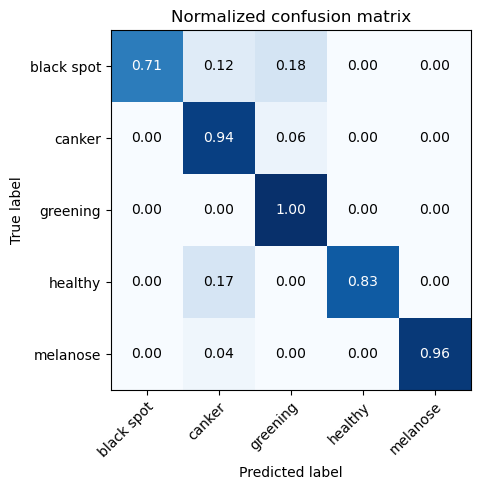

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')


# EfficientNet B4 model

In [1]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPool2D, BatchNormalization,Input,MaxPooling2D,GlobalMaxPooling2D,concatenate
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
plt.style.use('default')
from skimage.io import imread
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


import keras
import keras.backend as K
from keras.preprocessing.image import  ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
from keras.utils.np_utils import to_categorical

from keras.applications.vgg16 import VGG16
from keras.utils.data_utils import get_file

from keras import layers
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint


from sklearn.model_selection import train_test_split



In [2]:
import efficientnet.tfkeras as efn
model_eff =efn.EfficientNetB4(weights ='imagenet', include_top=False, input_shape = (224,224,3))

model_eff.trainable=True
model_eff.summary()

Model: "efficientnet-b4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 48  1296        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 112, 112, 48  192         ['stem_conv[0][0]']              
                                )                                                   

In [3]:

model2 = Sequential([
    layers.Conv2D(16,(3,3),name="conv1",input_shape=(224,224,3),activation="relu",padding="same"),   
    layers.MaxPool2D((2,2),name="pool1"),
    layers.Dropout(0.1),
    layers.Conv2D(32,(3,3),name="conv2",padding="same"),
    layers.Activation("relu"),
    layers.MaxPool2D((2,2),name="pool2"),
    layers.Dropout(0.1),
    layers.Conv2D(64,(3,3),name="conv3",padding="same"),
    layers.Activation("relu"),
    layers.MaxPool2D((2,2),name="pool3"),
    layers.Dropout(0.1),
    layers.Flatten(),
    layers.Dense(128,activation="relu"),
    layers.Dropout(0.1),
  
    layers.Dense(5,name="prepredictions"),
    layers.Activation("softmax",name="prediction")
]
)

model2.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["acc"])

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 224, 224, 16)      448       
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 16)      0         
                                                                 
 dropout (Dropout)           (None, 112, 112, 16)      0         
                                                                 
 conv2 (Conv2D)              (None, 112, 112, 32)      4640      
                                                                 
 activation (Activation)     (None, 112, 112, 32)      0         
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 32)        0         
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 32)        0

In [8]:
history = model2.fit_generator(
    train_gen,
    steps_per_epoch = train_gen.n // 32,
    callbacks = [ckpt],
    validation_data = valid_gen,
    validation_steps = valid_gen.n // 32,
    epochs=30)

C:\Users\Admin\AppData\Local\Temp\ipykernel_2156\577129328.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model2.fit_generator(


Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 2.2277 - acc: 0.3249
Epoch 1: val_loss improved from inf to 1.28920, saving model to D:\model\ModelCheckpoint_mobilenet.hdf5
21/21 [==============================] - 19s 872ms/step - loss: 2.2277 - acc: 0.3249 - val_loss: 1.2892 - val_acc: 0.5312
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.1763 - acc: 0.4671
Epoch 2: val_loss improved from 1.28920 to 1.10007, saving model to D:\model\ModelCheckpoint_mobilenet.hdf5
21/21 [==============================] - 18s 830ms/step - loss: 1.1763 - acc: 0.4671 - val_loss: 1.1001 - val_acc: 0.4531
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 0.9538 - acc: 0.5449
Epoch 3: val_loss improved from 1.10007 to 0.95054, saving model to D:\model\ModelCheckpoint_mobilenet.hdf5
21/21 [==============================] - 17s 808ms/step - loss: 0.9538 - acc: 0.5449 - val_loss: 0.9505 - val_acc: 0.6406
Epoch 4/30
21/21 [=============================

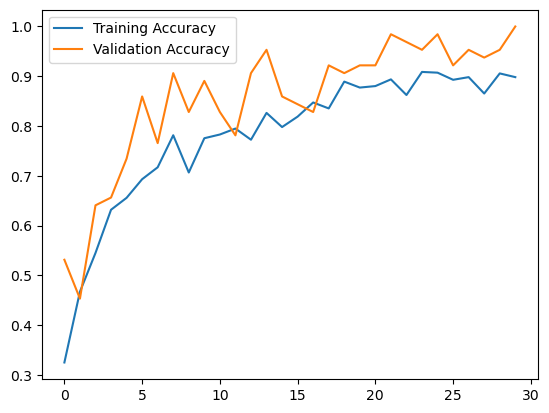

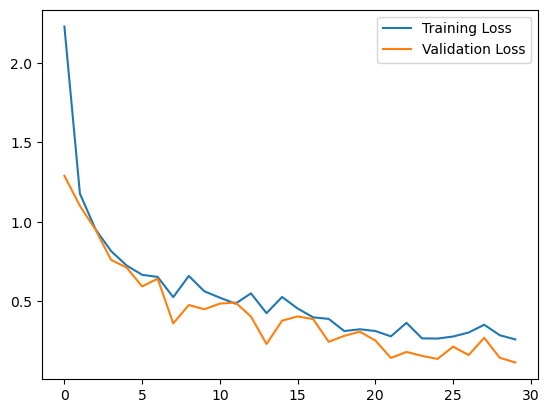

In [9]:
plt.plot(history.history["acc"],label="Training Accuracy")
plt.plot(history.history["val_acc"],label="Validation Accuracy")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Training Loss")
plt.plot(history.history["val_loss"],label="Validation Loss")
plt.legend()
plt.show()

In [4]:
model2.save('D:\\model\\new_efficientnet.h5')

In [11]:
y_pred = model2.predict(x_test)
y_pred

3/3 [==============================] - 0s 107ms/step


array([[4.68069455e-04, 1.06533921e-10, 9.99531984e-01, 1.36095431e-16,
        1.79562343e-09],
       [9.68914628e-01, 1.30612385e-02, 1.75095070e-02, 1.45097874e-04,
        3.69476998e-04],
       [4.27213877e-01, 4.73427296e-01, 9.64483693e-02, 8.74237448e-04,
        2.03618058e-03],
       [9.54383612e-01, 9.58175515e-05, 4.55129594e-02, 1.43109469e-06,
        6.13352449e-06],
       [0.00000000e+00, 0.00000000e+00, 4.59366425e-36, 0.00000000e+00,
        1.00000000e+00],
       [2.87063986e-01, 2.17034459e-01, 4.89549398e-01, 3.48448986e-03,
        2.86773965e-03],
       [8.86015445e-02, 1.36265293e-01, 7.56894708e-01, 1.74331907e-02,
        8.05287622e-04],
       [3.28759223e-01, 1.14102684e-01, 4.22927201e-01, 1.08870916e-01,
        2.53400579e-02],
       [1.48050055e-01, 5.35556069e-03, 8.44563186e-01, 6.05524168e-04,
        1.42567675e-03],
       [1.19079366e-01, 3.66269834e-02, 8.27674687e-01, 1.55725311e-02,
        1.04646338e-03],
       [9.96430099e-01, 4.4411

In [13]:
#check the model metrics
print(model2.metrics_names)

#evaluate training data
print(model2.evaluate(x= x_train, y = y_train))

#evaluate  validation data
print(model2.evaluate(x= x_valid, y = y_valid))

#evaluate  test data
print(model2.evaluate(x= x_test, y = y_test))     

['loss', 'acc']
22/22 [==============================] - 3s 133ms/step - loss: 0.2072 - acc: 0.9386
[0.20719872415065765, 0.9385714530944824]
3/3 [==============================] - 0s 118ms/step - loss: 0.1634 - acc: 0.9659
[0.16335682570934296, 0.9659090638160706]
3/3 [==============================] - 0s 117ms/step - loss: 0.2611 - acc: 0.9091
[0.2611076235771179, 0.9090909361839294]


In [14]:
from sklearn.metrics import classification_report

report = classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=class_names)

print(report)


              precision    recall  f1-score   support

  black spot       0.93      0.76      0.84        17
      canker       0.83      0.88      0.86        17
    greening       0.90      0.95      0.93        20
     healthy       1.00      1.00      1.00         6
    melanose       0.93      0.96      0.95        28

    accuracy                           0.91        88
   macro avg       0.92      0.91      0.91        88
weighted avg       0.91      0.91      0.91        88



In [16]:

#true label
y_true = np.argmax(y_test,axis=1)

#prediction label
Y_pred = model2.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)

print(y_true)
print()
print(y_pred)

3/3 [==============================] - 0s 107ms/step
[2 0 0 0 4 2 0 0 2 2 0 1 1 1 2 0 0 2 1 3 1 4 4 4 0 4 4 3 4 2 3 1 1 0 4 2 4
 4 0 2 3 1 4 0 1 4 1 4 4 2 1 4 4 2 4 4 4 4 4 2 2 0 0 4 4 4 4 1 2 1 2 2 4 1
 0 2 2 4 3 2 2 0 0 1 1 1 4 3]

[2 0 1 0 4 2 2 2 2 2 0 1 1 1 2 0 0 1 1 3 1 4 4 0 0 4 4 3 4 2 3 4 1 0 4 2 4
 4 0 2 3 1 4 0 1 4 1 4 4 2 1 4 4 2 4 4 4 4 4 2 2 0 0 4 4 4 4 1 2 1 2 2 4 1
 1 2 2 4 3 2 2 0 0 1 4 1 4 3]


Normalized confusion matrix
[[0.76 0.12 0.12 0.   0.  ]
 [0.   0.88 0.   0.   0.12]
 [0.   0.05 0.95 0.   0.  ]
 [0.   0.   0.   1.   0.  ]
 [0.04 0.   0.   0.   0.96]]


<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

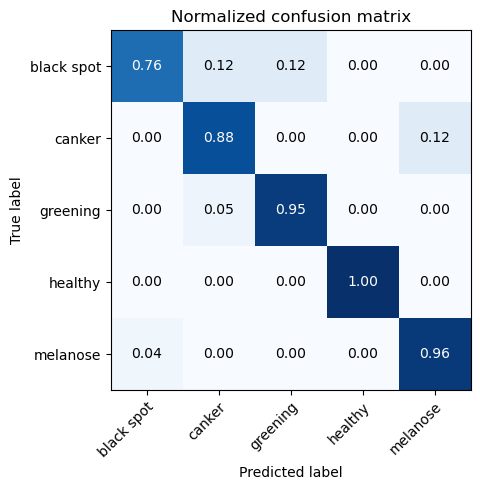

In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')


# GUI 

In [1]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import numpy as np
import tensorflow as tf

model = tf.keras.models.load_model("D:\\model\\new_MobileNet.h5")

# Define the GUI window and widgets

window = tk.Tk()
window.title('Citrus leaves Classifier')

# Create a label to display the image

image_label = tk.Label(window)
image_label.pack()

# Create a label to display the predicted class

class_label = tk.Label(window, font=('Arial', 25))
class_label.pack()

# Create a function to load and preprocess the image

def load_image(file_path):
    img = Image.open(file_path).convert('RGB')
    img = img.resize((224, 224))  # Resize the image to match the input size of the CNN
    img_array = np.array(img) / 255.0  # Convert the image to a numpy array and normalize its values
    img_array = np.expand_dims(img_array, axis=0)  # Add an extra dimension to the array to match the input shape of the CNN
    return img_array

def classify_image():
    file_path = filedialog.askopenfilename()
    if file_path:
        img_array = load_image(file_path)
        prediction = model.predict(img_array)[0]
        class_name = np.argmax(prediction)  # Get the index of the highest predicted probability
        class_label.config(text=f'Predicted class: {class_name}')
        

        # Display the input image in the GUI
        img = Image.open(file_path)
        img = img.resize((256, 256))
        img_tk = ImageTk.PhotoImage(img)
        image_label.config(image=img_tk)
        image_label.image = img_tk

# Create a button to trigger the image classification
classify_button = tk.Button(window, text='Classify', command=classify_image)
classify_button.pack()

window.mainloop()


1/1 [==============================] - 1s 849ms/step
